# Mise en situation

Vous êtes une jeune équipe de diplômés et vous voulez créer votre propre entreprise de fintech. Vous savez que la compagnie Crystal Dawn Private Qants essaie depuis des années de développer une stratégie de gestion de portefeuille efficace. 

Malheureusement une épidémie de *Lukehead Byus* a frappé leurs analystes avant qu'ils puissent livrer leur solution. Forts de cette information, vous ne laissez pas passer cette opportunité de leur vendre votre propre stratégie.

Votre espion qui évolue au sein de Crystal Dawn et qui a miraculeusement échappé à l'épidémie a réussi à vous obtenir un entretien vendredi prochain. 

Il vous fournit les exigeances de la compagnie qui doivent impérativement être respectées sans quoi vous n'aurez aucune chance de décrocher le contrat:

- Le portefeuille doit toujours comporter entre 80 et 120 titres.
- Vous ne pouvez investir que dans les 304 titres représentatifs du S&P 500 fournis avec le présent notebook.
- La stratégie doit être 'aveugle', il est interdit d'utiliser de l'information implicite liée au futur lorsque vous roulez votre stratégie sur les données historiques. (Vous risquez d'attraper le *Luckehead Byus*.)
- Vous pouvez rebalancer votre portefeuille chaque jour.


La compagnie à qui vous essayez de vendre votre stratégie va tenir des mini conférences le samedi matin ainsi que le dimanche. Assurez-vous d'y être pour récolter des informations supplémentaires sur ce à quoi elle sera attentive lors de votre présentation.

Note: *Se retirer complètement pendant une période est autorisé ($\sum w_i=0$) si le signal de retrait est produit algorithmiquement et non la conséquence d'une décision arbitraire, gare au Luckehead Byus !*

## Livrables
Pour passer l'entretien préliminaire vous devez fournir:
- Un notebook écrit en Python ou R fonctionnel avec certaines cellules de code obligatoires.
- Un fichier submission.csv contenant la pondération de votre portefeuille (le montant investi dans chaque titre) sur l'intervalle 2000-2006 avec un format correspondant au fichier `sample_submission.csv` 

Si vous passez l'entretien préliminaire, vous devrez préparer un rapide pitch de 6 minutes pour convaincre votre client potentiel de la qualité de votre stratégie. Crystal Dawn Private Quants vous demande d'absolument présenter:
- Un graphe du rendement de votre stratégie comparée au ticker SPY

Vous saurez mardi soir si vous avez passé cet entretien préliminaire.

In [17]:
#!pip install pandas seaborn matplotlib numpy statsmodels scikit-learn


In [18]:
import pandas as pd 
import statsmodels as sm 
import numpy as np 
import sklearn as sk
import matplotlib.pyplot as plt


## Loading data

In [19]:
ROOT='./kaggle/input/dt23-test/' # remove the dot (.) for the kaggle version

In [20]:
adjusted_close = pd.read_csv(ROOT+'series/adjusted_close.csv',index_col=0)
adjusted_close.index = pd.to_datetime(adjusted_close.index)
adjusted_close = adjusted_close.dropna(axis=1).iloc[:,:20]
adjusted_close.head()


,adjusted_close_CSCO,adjusted_close_DVN,adjusted_close_MRO,adjusted_close_BA,adjusted_close_GILD,adjusted_close_MDT,adjusted_close_MO,adjusted_close_CTRA,adjusted_close_MCHP,adjusted_close_EIX,adjusted_close_BBY,adjusted_close_GEN,adjusted_close_WBA,adjusted_close_DTE,adjusted_close_C,adjusted_close_T,adjusted_close_APH,adjusted_close_SYY,adjusted_close_MSI,adjusted_close_ADM
timestamp,,,,,,,,,,,,,,,,,,,,
2023-10-06,53.450000,43.70,24.59,187.38,74.74,76.12,42.07,26.80,79.54,62.06,68.76,17.35,21.81,95.16,40.57,14.450000,83.37,62.950000,276.14,72.86
2023-10-05,53.070000,42.85,24.24,186.29,74.70,76.15,41.99,26.11,77.35,60.69,67.63,16.99,22.18,94.20,39.88,14.550569,82.64,63.650000,273.23,73.13
2023-10-04,53.450000,43.35,24.40,186.73,74.74,76.27,41.65,25.83,77.77,61.23,68.56,17.14,22.29,97.11,39.81,14.373960,83.34,64.493375,274.23,73.47
2023-10-03,53.650000,45.75,25.68,188.92,73.27,76.54,41.13,26.34,76.75,61.23,67.61,17.36,22.55,97.36,39.86,14.501511,82.18,63.778987,271.49,73.81
2023-10-02,53.997474,45.65,25.59,187.83,74.10,77.77,41.58,26.32,78.37,61.04,69.09,17.53,22.42,95.49,40.50,14.393583,82.65,64.671972,272.92,74.20


## Pondération du portefeuille
Entrez ici les fonctions que vous utiliserez pour générer les poids de votre portefeuille sur base d'indicateurs tirés des données historiques ou produits avec des méthodes statistiques et/ou d'apprentissage machine.

**Assurez vous que la relation $\sum_{i=1}^{i=302}w_i=1$ est toujours respectée.**

Les méthodes que vous voyez ici ne sont pas valides pour la soumission finale:
 - `rand_weights`: sélectionne aléatoirement 5 titres et génère des poids aléatoires.
 - `best_return_fibo`: sélectionne les 10 meilleurs titres en fonction d'une prédiction sur leur rendement et leur assigne des poids proportionnels aux 10 premiers termes de la suite de Fibonacci.

In [21]:
def rand_weights(returns,*args,**kwargs):
    """
        Produces random weights for num_to_select assets 
    """
    weights = np.zeros(len(returns.T))
    num_to_select = 5

    # Generate unique random indices within the array size
    random_indices = np.random.choice(len(weights), num_to_select, replace=False)

    # Create a boolean mask based on the randomly selected indices
    mask = np.zeros(len(weights), dtype=bool)
    mask[random_indices] = True
    rw = np.random.rand(sum(mask))
    rw /= sum(rw)
    weights[mask]=rw
    return weights

def best_returns_fibo(returns,*args,**kwargs):
    """ 
        Selects the 10 best returns and assigns weights according to a fibonacci ratio 
    """
    weights = np.zeros(len(returns.T))

    # Select the indices of the 10 best stocks
    indices=np.argsort(returns.iloc[-1].values)[::-1][:10]

    # Generate weights according to a fibonacci sequence
    fibo = np.array([1, 1, 2, 3, 5, 8, 13, 21, 34, 55])[::-1].astype(float)
    fibo /= sum(fibo)

    # Create a boolean mask based on the randomly selected indices
    mask = np.zeros(len(weights), dtype=bool)
    mask[indices] = True
    
    weights[mask]=fibo
    return pd.Series({"weight_"+a.split('_')[-1]:b for a,b in zip(returns.columns,weights)})


## Modèle prédictif
Programmez ici vos modèles prédictifs et analytiques qui vous permettront de choisir la meilleure pondération possible étant donnée les données antérieures au moment du rebalancement.

C'est ici qu'il faut faire attention à ne pas attraper le *Lukehad Byus*, vous prenez de gros risques si les arguments de vos fonctions prennent en compte des données postérieures au moment du rebalancement ('savoir' à priori qu'AAPL va bien performer constitue une donnée postérieure). 

Le modèle actuel est très simpliste:
- `polynomial_regression`: effectue une simple régression avec un polynome du 3e degré pour essayer de prédire le rendement que fera chaque titre le lendemain.

In [22]:
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

def polynomial_regression(past_prices):
    """
        Fits a 3d degree polynomial for each asset and returns the predicted value
    """

    models={}

    # Fitting a 3d degree polynomial for each asset
    for c in past_prices.columns:
        x=past_prices[[c]]
        xp = PolynomialFeatures(degree=3).fit_transform(np.arange(len(x)).reshape((len(x),1)))
        model = sm.OLS(x.values, xp).fit()
        models[c] = model

    # Returning the expected return for the next timestep for all stocks
    return pd.DataFrame({k:v.predict(PolynomialFeatures(degree=3).fit_transform(np.array([len(x)]).reshape((1,1)))) for k,v in models.items()})/past_prices.iloc[-1]


## Rebalancement journalier

Vous choisissez ici ce que vous fournissez aux fonctions précédemment implémentées.

L'utilisation de `rolling()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)) est pratiquement obligatoire pour éviter d'incorporer les données futures dans votre système.

Si vous ne respectez pas l'intervalle `2000-01-01`-`2006-01-01` votre solution ne sera pas acceptée.

In [23]:
weights_df = []
index = []
adjusted_close=adjusted_close.sort_index()
start,stop = pd.to_datetime('2000-01-01'),pd.to_datetime('2006-01-01')
for x in adjusted_close[(adjusted_close.index>=pd.to_datetime(start))&(adjusted_close.index<pd.to_datetime(stop))].rolling(30):
    if len(x)==30:
        index.append(x.index.max())
        weights_df.append(best_returns_fibo(polynomial_regression(x)))


Génération de la soumission avec le format requis.

In [24]:
weights_df = pd.DataFrame(weights_df,index=index)
weights_df.to_csv('sample_submission.csv')


## Evaluation

In [25]:
prices_df = adjusted_close.loc[weights_df.index]
returns_df = prices_df.shift(-1)/prices_df


In [26]:
bmrk = pd.read_csv(ROOT+'series/benchmark/SPY_returns.csv',index_col=0)
bmrk.index = pd.to_datetime(bmrk.index)


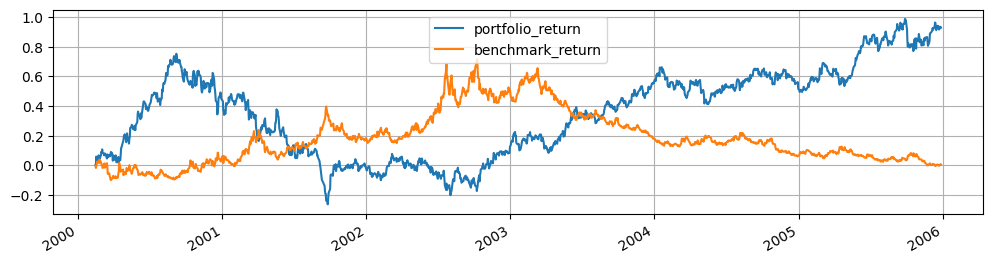

In [27]:
porfolio_performance = pd.DataFrame(pd.DataFrame(returns_df.values*weights_df.values, columns=weights_df.columns, index=weights_df.index).sum(axis=1),columns=['portfolio_return'])[:-2]
daily_returns = porfolio_performance.merge(bmrk,left_index=True,right_index=True,how='left')-1
cumulative_returns = ((daily_returns+1).cumprod()-1)
cumulative_returns.plot(figsize=(12,3))
plt.grid()


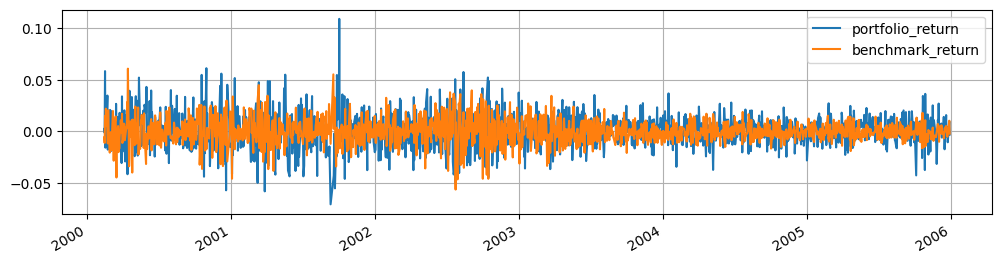

In [28]:
daily_returns.plot(figsize=(12,3))
plt.grid()


In [29]:
cov_matrix = daily_returns.cov()
beta = cov_matrix['portfolio_return']['benchmark_return']/cov_matrix['benchmark_return']['benchmark_return']
beta


-0.005192299107921514

In [30]:
us10bond = pd.read_csv(ROOT+'series/additional_data/us_10ybond_yield.csv',index_col=0)
us10bond.index = pd.to_datetime(us10bond.index)

usCPI = pd.read_csv(ROOT+'series/additional_data/us_CPI.csv',index_col=0)
usCPI.index = pd.to_datetime(usCPI.index)

cpi_idx = lambda x:usCPI[usCPI.index<=pd.to_datetime(x)].index.max()
cumulative_inflation = lambda a,b:(usCPI.loc[cpi_idx(b)]['CPI']-usCPI.loc[cpi_idx(a)]['CPI'])/usCPI.loc[cpi_idx(a)]['CPI']

# risk free rate = 10y bond yield/inflation
rf = ((1+us10bond[us10bond.index<=start].sort_index()['Yield'].values[-1])/100)/cumulative_inflation(start,stop) - 1

# returns
r = cumulative_returns['portfolio_return'].values[-1]
rm = cumulative_returns['benchmark_return'].values[-1]

alpha = r-rf-beta*(rm-rf)
alpha


1.50652345995838

In [31]:
rf,r,rm,alpha,beta


(-0.574566782935191,
 0.9289407677947825,
 0.006275954688565788,
 1.50652345995838,
 -0.005192299107921514)

Return over Max Drawdown

In [32]:
# https://www.investopedia.com/terms/r/return-over-maximum-drawdown-romad.asp
max_draw_down = ((cumulative_returns.cummax()-cumulative_returns)).max()
c_return = cumulative_returns.iloc[-1]
c_return/max_draw_down

portfolio_return    0.915067
benchmark_return    0.008708
dtype: float64